In [11]:
!pip3 install --upgrade pip
!pip3 install --upgrade google-cloud-vision
!pip3 install --upgrade google-cloud-storage

Requirement already up-to-date: pip in /usr/local/envs/py3env/lib/python3.5/site-packages (19.0.3)
Requirement already up-to-date: google-cloud-vision in /usr/local/envs/py3env/lib/python3.5/site-packages (0.36.0)
Requirement already up-to-date: google-cloud-storage in /usr/local/envs/py3env/lib/python3.5/site-packages (1.14.0)


In [12]:
import io
from enum import Enum
from PIL import Image, ImageDraw

In [38]:
def detect_document(path):
    """Detects document features in an image."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)

    response = client.document_text_detection(image=image)
    
    return response

In [14]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

In [15]:
def draw_boxes(image, bounds, color, width=1):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y], fill=color, width=width)
    return image

In [16]:
def get_document_bounds(response, feature):
    """Returns document bounds given an image."""
    bounds = []
    
    # Collect specified feature bounds by enumerating all document features
    for i, page in enumerate(document.pages):
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)
            
    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds

## Document Text Exploration

In [41]:
# path = './sample_img_files/thai-citizenid.jpg'
path = './sample_img_files/thai-payslip.jpg'
# path = './sample_img_files/thai-krungsri-bookbank.jpg'

In [42]:
response = detect_document(path)
document = response.full_text_annotation

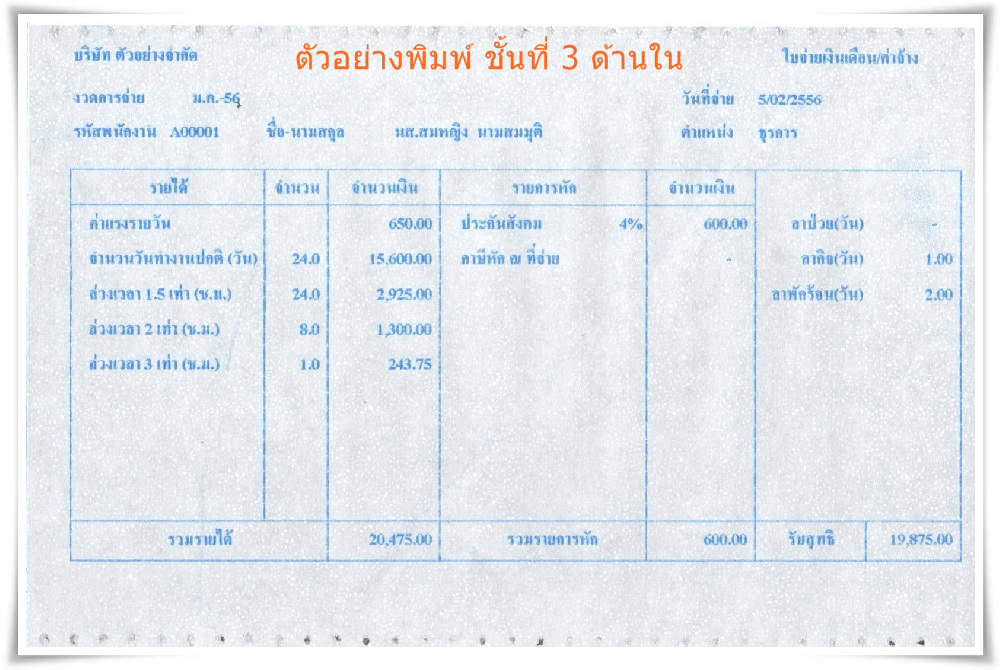

In [43]:
image = Image.open(path)
image

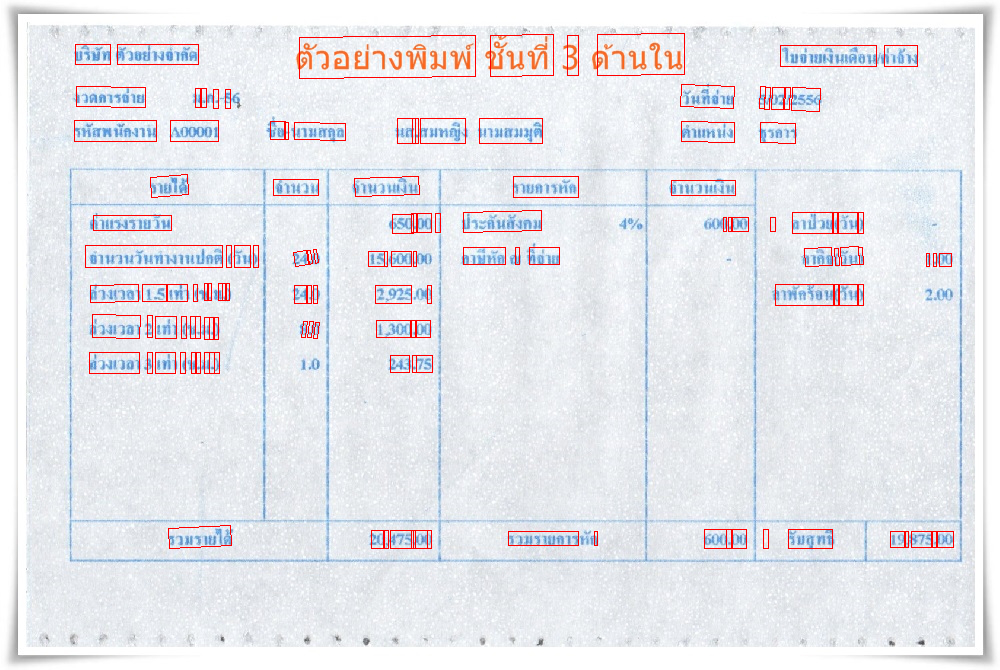

In [44]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'red')

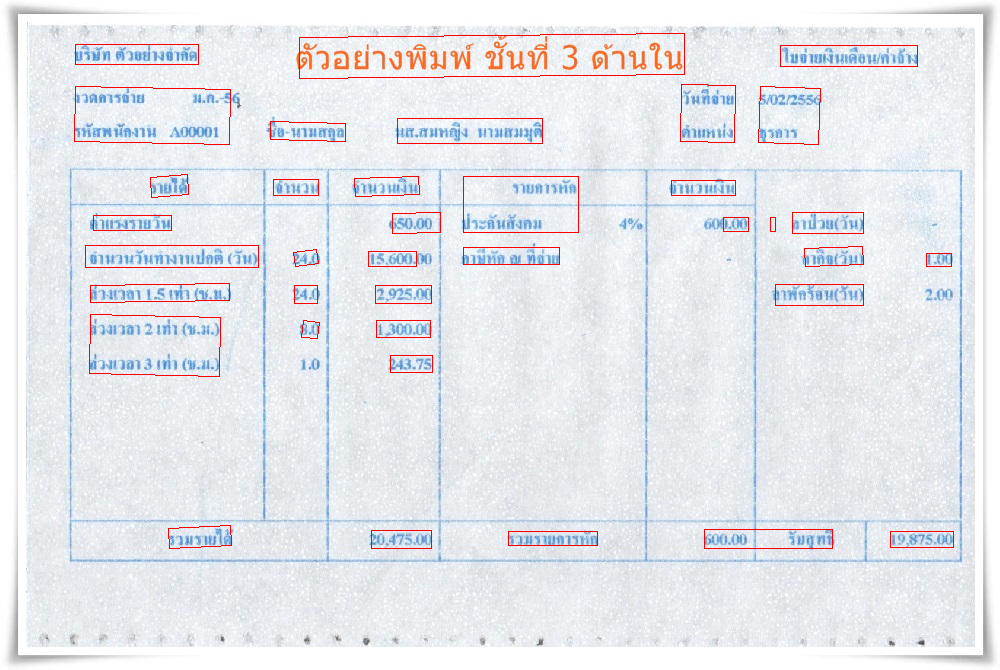

In [45]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.PARA)
draw_boxes(image, bounds, 'red')

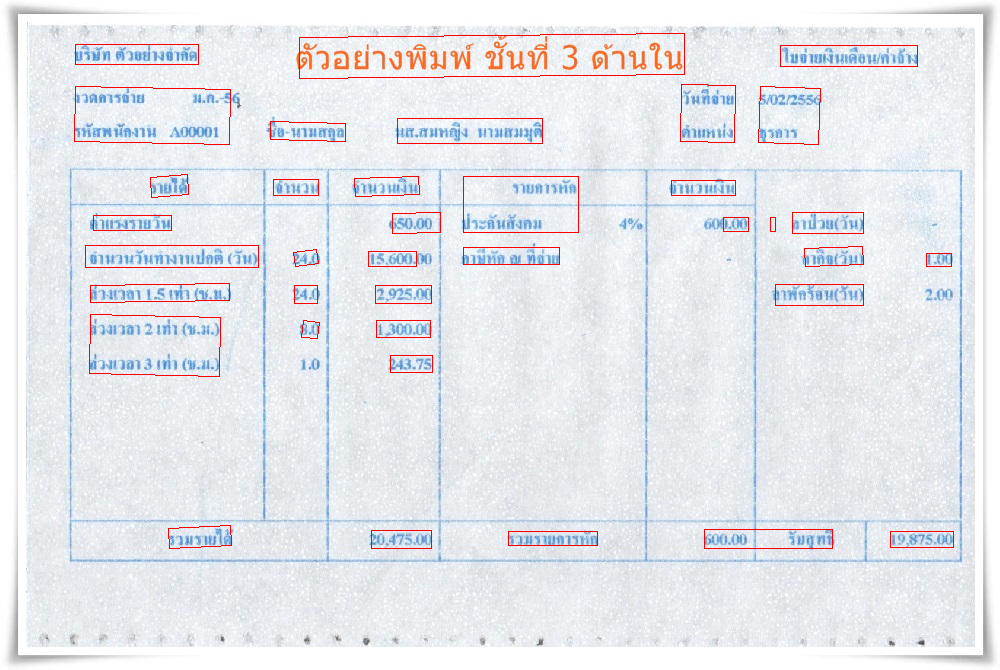

In [46]:
image = Image.open(path)
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, bounds, 'red')

In [48]:
for page in response.full_text_annotation.pages:
    for block in page.blocks:
        print('\nBlock confidence: {}\n'.format(block.confidence))

        for paragraph in block.paragraphs:
            print('Paragraph confidence: {}'.format(
                paragraph.confidence))

            for word in paragraph.words:
                word_text = ''.join([
                    symbol.text for symbol in word.symbols
                ])
                print('Word text: {} (confidence: {})'.format(
                    word_text, word.confidence))

#                 for symbol in word.symbols:
#                     print('\tSymbol: {} (confidence: {})'.format(
#                         symbol.text, symbol.confidence))


Block confidence: 0.8500000238418579

Paragraph confidence: 0.8500000238418579
Word text: บริษัท (confidence: 0.9900000095367432)
Word text: ตัวอย่างอากัด (confidence: 0.7799999713897705)

Block confidence: 0.9800000190734863

Paragraph confidence: 0.9800000190734863
Word text: ตัวอย่างพิมพ์ (confidence: 0.9900000095367432)
Word text: ชั้นที่ (confidence: 0.9800000190734863)
Word text: 3 (confidence: 1.0)
Word text: ด้านใน (confidence: 0.9700000286102295)

Block confidence: 0.8100000023841858

Paragraph confidence: 0.8100000023841858
Word text: ใบจ่ายเงินเดือน (confidence: 0.8999999761581421)
Word text: ค่าจ้าง (confidence: 0.6200000047683716)

Block confidence: 0.7699999809265137

Paragraph confidence: 0.7699999809265137
Word text: งวดการถ่าย (confidence: 0.699999988079071)
Word text: ม (confidence: 0.5199999809265137)
Word text: . (confidence: 0.8500000238418579)
Word text: . (confidence: 0.5099999904632568)
Word text: 5 (confidence: 0.41999998688697815)
Word text: รหัสพนักงาน (conf